<a href="https://colab.research.google.com/github/kavyajeetbora/ETL_wages/blob/master/WIOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation and Import

In [1]:
# !pip install -q pyxlsb

In [35]:
%%time
# !wget https://dataverse.nl/api/access/datafile/199104 -O wiot.zip
!wget -q https://dataverse.nl/api/access/datafile/199097 -O exchange_rates.xlsx
!wget -q https://dataverse.nl/api/access/datafile/199095 -O sea.xlsx
!wget -q https://dataverse.nl/api/access/datafile/354108 -O NA_data.xlsx
!wget -q https://raw.githubusercontent.com/kavyajeetbora/ETL_wages/master/data/PPP_export.csv -O ppp.csv

CPU times: user 41.5 ms, sys: 7.13 ms, total: 48.6 ms
Wall time: 3.24 s


In [103]:
import pandas as pd
from zipfile import ZipFile
from tqdm import tqdm
import seaborn as sns
# from pyxlsb import open_workbook as open_xlsb

## SEA

In [4]:
%%time
sea = pd.read_excel("sea.xlsx", sheet_name='DATA')

CPU times: user 18.9 s, sys: 360 ms, total: 19.2 s
Wall time: 29.7 s


In [5]:
sea.head(3)

,country,variable,description,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,AUS,CAP,"Crop and animal production, hunting and relate...",A01,9739.77,13729.03,9726.30,11808.62,11163.98,12429.90,8706.66,11227.29,12556.71,13768.79,18441.27,20106.04,19659.28,18986.06,20525.22
1,AUS,CAP,Forestry and logging,A02,582.69,740.04,540.79,651.96,649.34,676.64,549.27,616.70,716.86,749.91,894.94,923.40,1001.44,1247.96,1206.44
2,AUS,CAP,Fishing and aquaculture,A03,869.31,1122.29,652.69,1024.72,1059.83,923.46,904.15,863.98,1146.37,1108.94,1116.14,1213.94,1182.11,1388.98,1475.22


In [6]:
year_range = list(range(2000,2015))

## Convert to USD $

In [7]:
exchange = pd.read_excel('exchange_rates.xlsx', sheet_name='EXR', header=3)
exchange.columns = list(exchange.columns[:2].str.lower()) + [int(c.replace("_", "")) for c in exchange.columns[2:]]
exchange.loc[exchange['acronym']=='ROM', 'acronym'] = 'ROU'
exchange = pd.melt(exchange, id_vars=['acronym'], value_vars=list(range(2000,2015)), var_name='Year')
exchange.head(3)

,acronym,Year,value
0,AUS,2000,0.582346
1,AUT,2000,0.923600
2,BEL,2000,0.923600


In [8]:
SEA = pd.melt(sea, id_vars=['country','variable','code'], value_vars= year_range, var_name='year')
SEA.head(3)

,country,variable,code,year,value
0,AUS,CAP,A01,2000,9739.77
1,AUS,CAP,A02,2000,582.69
2,AUS,CAP,A03,2000,869.31


In [9]:
SEA_USD = pd.merge(left=SEA,
         right=exchange,
         how='left',
         left_on=SEA['country']+SEA['year'].astype(str),
         right_on=exchange['acronym']+exchange['Year'].astype(str),
         suffixes=('', '_y')
)

SEA_USD['value'] = SEA_USD['value']*SEA_USD['value_y']
SEA_USD = SEA_USD.drop(['key_0', 'value_y', 'acronym', 'Year'], axis=1)

## Unpivot changes
SEA_USD = SEA_USD.pivot(columns=['year'], index=['country','variable', 'code'], values='value').reset_index()
SEA_USD.head(3)

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,AUS,CAP,A01,5671.916100,7106.640173,5290.163749,7697.850440,8223.153224,9494.504536,6559.162311,9414.767530,10739.314578,10895.298602,16956.729324,20753.655548,20363.082224,18386.613128,18528.013468
1,AUS,CAP,A02,339.327191,383.071345,294.137303,425.002293,478.290208,516.847404,413.792554,517.140569,613.105268,593.406783,822.896435,953.142714,1037.291552,1208.558159,1089.047356
2,AUS,CAP,A03,506.239201,580.937706,355.000049,667.998572,780.648522,705.379380,681.141402,724.499933,980.450138,877.508658,1026.289614,1253.041007,1224.429538,1345.125734,1331.673718


## Adjusted USD $

In [10]:
GO_PI = sea.loc[sea['variable']=='GO_PI'].copy()
GO_PI[GO_PI.columns[4:]] = GO_PI[GO_PI.columns[4:]]/100
GO_PI = pd.melt(GO_PI, id_vars=['country','variable', 'code'], value_vars=year_range, var_name='Year')
GO_PI.head(3)

,country,variable,code,Year,value
0,AUS,GO_PI,A01,2000,0.91576
1,AUS,GO_PI,A02,2000,0.91576
2,AUS,GO_PI,A03,2000,0.91576


In [11]:
SEA = SEA_USD.copy()
SEA = pd.melt(SEA, id_vars=['country','variable','code'], value_vars= year_range, var_name='year')
SEA.head(3)

,country,variable,code,year,value
0,AUS,CAP,A01,2000,5671.916100
1,AUS,CAP,A02,2000,339.327191
2,AUS,CAP,A03,2000,506.239201


In [12]:
adj_USD = pd.merge(left=SEA,
         right=GO_PI,
         how='left',
         left_on=SEA['country']+SEA['year'].astype(str)+SEA['code'],
         right_on=GO_PI['country']+GO_PI['Year'].astype(str)+GO_PI['code'],
         suffixes=('', '_y')
)
adj_USD['value'] = adj_USD['value']*adj_USD['value_y']
adj_USD = adj_USD.drop(['key_0', 'country_y','variable_y','code_y', 'Year', 'value_y'], axis=1)

## Unpivot changes
adj_USD = adj_USD.pivot(columns=['year'], index=['country','variable', 'code'], values='value').reset_index()
adj_USD.sample(4)

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
13664,FRA,GO,A01,54790.971581,56443.864978,58024.031537,72639.190685,76664.860923,76818.676334,72701.140012,94201.053048,105341.455471,85212.877081,95311.201500,113135.513400,116186.503235,114505.285338,109616.530699
30945,PRT,II,H52,1225.670437,1319.134178,1482.797917,1963.912414,2455.974590,2890.891319,3288.759171,4098.574969,4955.856510,4015.562609,4272.200820,4786.512356,3487.145798,3739.425015,3791.587887
14668,GBR,GO_PI,Q,89.463400,91.504284,104.904891,122.386630,153.245571,156.094931,175.751184,201.901187,185.839559,162.838721,154.611000,159.242640,155.435878,143.746336,157.466767
36039,TUR,EMPE,H50,27.642475,23.101071,22.578551,27.169993,30.684531,34.570556,34.773915,41.456496,45.350537,40.654890,44.384567,46.798500,53.745751,58.785674,61.742741


## Industry PPP in Adjusted USD $



In [13]:
ppp1 = adj_USD.groupby(['code','variable']).sum().reset_index()
ppp1 = ppp1.drop(['country'], axis=1)
ppp1[ppp1['variable']=='GO'].sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
116,C17,GO,439093.912125,415516.654342,413225.734056,4.483398e+05,5.029789e+05,5.345548e+05,5.887147e+05,6.774959e+05,7.726403e+05,7.060884e+05,7.979078e+05,9.166068e+05,9.020009e+05,9.381458e+05,9.555726e+05
244,C25,GO,796382.859520,753220.303636,755447.079752,8.476788e+05,1.025575e+06,1.167354e+06,1.338382e+06,1.626995e+06,1.908817e+06,1.598609e+06,1.743233e+06,2.070095e+06,2.162044e+06,2.248654e+06,2.300003e+06
532,H52,GO,413488.261489,424789.326608,469048.949258,5.719986e+05,6.614464e+05,7.326948e+05,8.230461e+05,9.943451e+05,1.185033e+06,1.062310e+06,1.194255e+06,1.378283e+06,1.412741e+06,1.489091e+06,1.560983e+06
164,C20,GO,914715.535247,876500.669475,900232.361250,1.072224e+06,1.312530e+06,1.593621e+06,1.796635e+06,2.196812e+06,2.721419e+06,2.209358e+06,2.795177e+06,3.569960e+06,3.674374e+06,3.896686e+06,3.916706e+06
148,C19,GO,397153.436048,380830.387113,389222.744901,5.079497e+05,7.434512e+05,1.190246e+06,1.611900e+06,1.976988e+06,2.897924e+06,1.793603e+06,2.611160e+06,4.018208e+06,4.298864e+06,4.156576e+06,3.965962e+06


## Industry Total in Current Dollars

In [14]:
ppp2 = SEA_USD.groupby(['code','variable']).sum().reset_index()
ppp2 = ppp2.drop(['country'], axis=1)
ppp2[ppp2['variable']=='GO'].sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
580,J58,GO,4.680493e+05,4.627106e+05,4.716662e+05,4.994333e+05,5.462993e+05,5.641196e+05,5.892000e+05,6.379172e+05,6.685555e+05,6.117986e+05,6.118300e+05,6.421921e+05,6.238198e+05,6.291750e+05,6.444535e+05
804,O84,GO,3.731891e+06,3.837787e+06,4.087199e+06,4.539622e+06,4.985178e+06,5.314170e+06,5.659341e+06,6.194429e+06,6.849874e+06,6.941249e+06,7.288377e+06,7.723978e+06,7.748140e+06,7.764141e+06,7.901780e+06
292,C28,GO,1.135162e+06,1.081537e+06,1.087130e+06,1.250850e+06,1.474551e+06,1.633388e+06,1.850815e+06,2.206494e+06,2.528965e+06,2.163276e+06,2.382043e+06,2.866950e+06,2.872551e+06,2.977235e+06,3.060489e+06
452,G46,GO,2.871941e+06,2.797533e+06,2.895514e+06,3.227758e+06,3.673503e+06,3.936040e+06,4.254725e+06,4.839157e+06,5.421203e+06,4.726237e+06,5.319552e+06,6.045337e+06,6.170111e+06,6.382640e+06,6.561648e+06
164,C20,GO,1.239579e+06,1.167367e+06,1.197683e+06,1.375238e+06,1.605788e+06,1.843065e+06,2.028854e+06,2.391725e+06,2.730899e+06,2.325873e+06,2.795177e+06,3.350245e+06,3.434159e+06,3.583113e+06,3.643842e+06


## PPP Ratio

In [15]:
ppp_ratio = ppp2.copy()
ppp_ratio.loc[:,year_range] =  ppp2.loc[:,year_range] / ppp1.loc[:,year_range]
ppp_ratio.sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
820,P85,GO,1.345208,1.315460,1.283354,1.247247,1.223578,1.197068,1.163679,1.119706,1.064414,1.026221,1.0,0.965292,0.935267,0.897156,0.872244
327,C30,H_EMPE,1.135549,1.097962,1.029941,0.993487,0.958217,0.968996,0.960482,0.977363,0.980718,0.955055,1.0,0.940804,0.950669,0.940227,0.930925
253,C25,VA,1.247470,1.243419,1.241760,1.229919,1.181448,1.133519,1.106634,1.068115,1.003941,1.005614,1.0,0.969941,0.961326,0.946053,0.945899
490,H49,II_QI,1.634342,1.487884,1.404796,1.317380,1.287008,1.241203,1.163333,1.111521,1.055295,1.024709,1.0,0.961548,0.939729,0.921754,0.912471
726,M71,GO_QI,1.221240,1.195161,1.160164,1.112116,1.094886,1.080711,1.057632,1.023117,1.002733,0.991490,1.0,0.993033,0.986262,0.978293,0.984796


## Load PPP Exchange Rate


$V_{GDP} / PPP$

In [16]:
PPP = pd.read_csv('ppp.csv')
PPP = pd.melt(PPP, id_vars=['ISO code','Country', 'Variable code', 'Variable name'], value_vars=[str(i) for i in year_range], var_name='year')
PPP.head(3)

,ISO code,Country,Variable code,Variable name,year,value
0,ABW,Aruba,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,4519.512695
1,AGO,Angola,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,37817.11719
2,AIA,Anguilla,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,273.9180298


In [18]:
NA_data = pd.read_excel('NA_data.xlsx', sheet_name='Data')
NA_data = NA_data[NA_data['year'].isin(year_range)][['countrycode', 'year', 'v_gdp']]
NA_data.head(3)

,countrycode,year,v_gdp
30,ABW,2000,3514.117257
31,ABW,2001,3601.926718
32,ABW,2002,3640.996725


In [19]:
PPP_exchange = pd.merge(left=PPP,
         right=NA_data,
         how='left',
         left_on=PPP['ISO code']+PPP['year'].astype(str),
         right_on=NA_data['countrycode']+NA_data['year'].astype(str),
         suffixes=('', '_y')
)
PPP_exchange['value'] = PPP_exchange['value'].str.replace(',','').astype(float)
PPP_exchange['value'] = PPP_exchange['v_gdp']/PPP_exchange['value']

PPP_exchange = PPP_exchange.drop(['key_0', 'countrycode','year_y','v_gdp'], axis=1)
PPP_exchange.dropna(inplace=True)
PPP_exchange

,ISO code,Country,Variable code,Variable name,year,value
0,ABW,Aruba,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.777543
1,AGO,Angola,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,3.241085
2,AIA,Anguilla,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,1.480888
3,ALB,Albania,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,31.437671
4,ARE,United Arab Emirates,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,1.087202
...,...,...,...,...,...,...
2852,VNM,Viet Nam,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,7333.596077
2853,YEM,Yemen,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,76.196263
2854,ZAF,South Africa,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,5.441281
2855,ZMB,Zambia,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,3.118285


## Industry PPP Exchange Rate

In [49]:
countries = SEA['country'].unique()
PPP_exchage_filtered = PPP_exchange[PPP_exchange['ISO code'].isin(countries)]
PPP_exchage_filtered.head(3)

,ISO code,Country,Variable code,Variable name,year,value
8,AUS,Australia,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.946925
9,AUT,Austria,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.690997
12,BEL,Belgium,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.703575


In [21]:
X1 = ppp_ratio.melt(id_vars=['code', 'variable'], value_vars=year_range)
X1.head(3)

,code,variable,year,value
0,A01,CAP,2000,1.532604
1,A01,COMP,2000,1.721800
2,A01,EMP,2000,2.065999


In [90]:
%%time

country_industry_ppp_rate_dfs = []

for country, dfx in tqdm(PPP_exchage_filtered.groupby('ISO code'), unit=' country'):
    for year in year_range:
        # X1[X1['year']==year]
        val = dfx.loc[(dfx['year']==str(year)),'value'].values[0]

        ppp_ratio_x = X1[X1['year']==year]
        rates = val*ppp_ratio_x['value'].values

        dfy = pd.DataFrame({'country_industry_ppp_rate': rates})
        dfy['country'] = country
        dfy['year'] = year
        dfy['code'] = ppp_ratio_x['code'].values
        dfy['variable'] = ppp_ratio_x['variable'].values
        dfy = dfy[['country', 'year', 'code', 'variable', 'country_industry_ppp_rate']]

        country_industry_ppp_rate_dfs.append(dfy)

country_industry_ppp_rate_df = pd.concat(country_industry_ppp_rate_dfs)
country_industry_ppp_rate_df.sample(5)

100%|██████████| 43/43 [00:03<00:00, 13.45 country/s]


CPU times: user 3.22 s, sys: 69.8 ms, total: 3.29 s
Wall time: 3.37 s


,country,year,code,variable,country_industry_ppp_rate
446,DEU,2009,G45,VA_PI,0.715334
541,MEX,2008,H52,VA,7.145071
299,DEU,2011,C28,K,0.694702
734,BEL,2006,M71,VA_PI,0.770014
98,GRC,2003,C16,EMP,0.685987


## Homogeneous Labour



In [157]:
## Homogeneous Labour with Adjusted Dollar
ppp1_GO = ppp1[ppp1['variable']=='GO'].melt(id_vars = ['code', 'variable'], value_vars=year_range)
ppp1_GO.sample(3)

## Homogeneous Labour with Standard Dollar
ppp2_GO = ppp2[ppp2['variable']=='GO'].melt(id_vars = ['code', 'variable'], value_vars=year_range)
ppp2_GO.sample(3)

,code,variable,year,value
110,T,GO,2001,97480.466509
1,A02,GO,2000,121631.484889
623,C17,GO,2011,883542.166655


In [158]:
hom_labour = country_industry_ppp_rate_df[country_industry_ppp_rate_df['variable']=='GO'].copy()
hom_labour['homogeneous'] = hom_labour['country_industry_ppp_rate'].values*SEA[SEA['variable']=='GO']['value'].values
hom_labour.head()

,country,year,code,variable,country_industry_ppp_rate,homogeneous
4,AUS,2000,A01,GO,1.393741,40345.964653
20,AUS,2000,A02,GO,1.200858,1808.590518
36,AUS,2000,A03,GO,1.276163,1930.047767
52,AUS,2000,B,GO,2.004125,68165.349810
68,AUS,2000,C10-C12,GO,1.221949,41752.020838


In [161]:
%%time

hom_labours = []
for country,dfx in tqdm(hom_labour.groupby('country'), unit=' country'):

    x_merge = pd.merge(left = dfx,
        right=ppp2_GO,
        left_on=dfx['year'].astype(str)+dfx['code'],
        right_on=ppp2_GO['year'].astype(str)+ppp2_GO['code'],
        how='inner',
        suffixes=('', '_y')
    )
    x_merge['h2'] = x_merge['homogeneous']/x_merge['value']
    x_merge = x_merge.drop(['key_0','code_y', 'variable_y', 'year_y', 'country_industry_ppp_rate', 'value'], axis=1)

    x_merge = pd.merge(left = x_merge,
        right=ppp1_GO,
        left_on=dfx['year'].astype(str)+dfx['code'],
        right_on=ppp1_GO['year'].astype(str)+ppp1_GO['code'],
        how='inner',
        suffixes=('', '_y')
    )
    x_merge['h3'] = x_merge['homogeneous']/x_merge['value']
    x_merge = x_merge.drop(['key_0','code_y', 'variable_y', 'year_y', 'homogeneous', 'value'], axis=1)

    hom_labours.append(x_merge)

hom_labour2 = pd.concat(hom_labours)
hom_labour2.head()

100%|██████████| 43/43 [00:00<00:00, 72.97 country/s]

CPU times: user 600 ms, sys: 9.43 ms, total: 610 ms
Wall time: 618 ms


,country,year,code,variable,h2,h3
0,AUS,2000,A01,GO,0.031541,0.046424
1,AUS,2000,A02,GO,0.014869,0.018857
2,AUS,2000,A03,GO,0.020100,0.027089
3,AUS,2000,B,GO,0.092243,0.195228
4,AUS,2000,C10-C12,GO,0.018921,0.024416


<Axes: xlabel='year', ylabel='h2'>

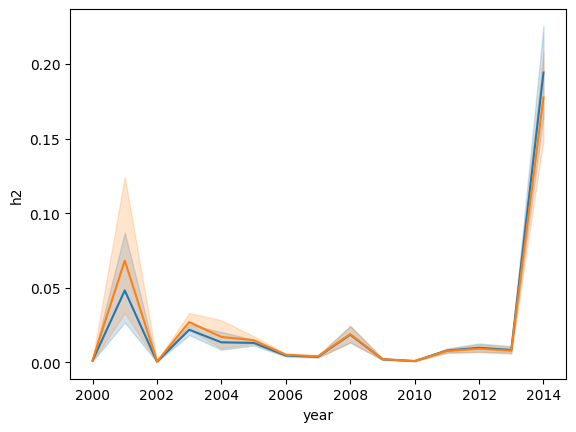

In [165]:
data_filter = hom_labour2[hom_labour2['country']=='USA']
sns.lineplot(data=data_filter, x='year', y='h2')
sns.lineplot(data=data_filter, x='year', y='h3')

## World Input Output Analysis

In [170]:
hours = SEA[SEA['variable']=='H_EMPE'].copy().drop(['country','variable'],axis=1)
hours.groupby(['year','code']).sum().reset_index()

,year,code,value
0,2000,A01,24210.180509
1,2000,A02,2538.245812
2,2000,A03,999.393418
3,2000,B,3184.563497
4,2000,C10-C12,15003.757675
...,...,...,...
835,2014,P85,40025.780805
836,2014,Q,79777.449611
837,2014,R_S,30201.108765
838,2014,T,12657.733161


In [25]:
H_EMPE

In [26]:
# %%time
# df = pd.read_excel('WIOT2000_Nov16_ROW.xlsb', engine='pyxlsb')

In [27]:
# df.head(10)

In [28]:
# industries = df.iloc[5:, :3].reset_index(drop=True).copy()
# industries.columns = ['code', 'industry', 'country']
# print('Total number of industries',industries.shape[0])
# industries

In [29]:
# value = df.iloc[5:, 4:industries.shape[0]+4].copy()
# value.columns = industries['code']
# value['industry'] = industries['code']
# value['country'] = industries['country']
# value.sample(5)

In [30]:
# isProductive = ['K64', 'K65', 'K66', 'L68', 'M69_M70', 'N', 'O84', 'T', 'U']

# value[value['industry'].isin(isProductive)].groupby('country').sum().iloc[:,:-1].sum(axis=1)